In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Dataset Link https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

In [2]:
tmp_dir = 'alien_predator/data'
os.path.join(tmp_dir)

'alien_predator/data'

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'alien_predator/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 694
     Root location: alien_predator/data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 200
     Root location: alien_predator/data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [5]:
class_names

['alien', 'predator']

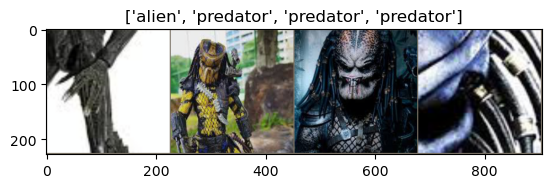

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from Tensor image
    # to numpy image, unnormalize
    # Reverse normalization
    # Note: The mean and std values are for the ImageNet dataset.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
train_losses, val_accuracies = [], []
train_accuracies, val_losses = [], []

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                elif phase == 'val':
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training # true =-> model was in training mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
from torchvision.models import ResNet18_Weights
model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/25
----------
train Loss: 0.6032 Acc: 0.7248
val Loss: 0.2716 Acc: 0.8800

Epoch 1/25
----------
train Loss: 0.6491 Acc: 0.7464
val Loss: 0.2852 Acc: 0.8950

Epoch 2/25
----------
train Loss: 0.4734 Acc: 0.8069
val Loss: 0.4073 Acc: 0.8400

Epoch 3/25
----------
train Loss: 0.4969 Acc: 0.7723
val Loss: 0.3489 Acc: 0.8450

Epoch 4/25
----------
train Loss: 0.6138 Acc: 0.7795
val Loss: 0.3861 Acc: 0.8500

Epoch 5/25
----------
train Loss: 0.6335 Acc: 0.7781
val Loss: 0.2148 Acc: 0.8950

Epoch 6/25
----------
train Loss: 0.4209 Acc: 0.8386
val Loss: 0.1715 Acc: 0.9350

Epoch 7/25
----------
train Loss: 0.3215 Acc: 0.8602
val Loss: 0.1628 Acc: 0.9350

Epoch 8/25
----------
train Loss: 0.3124 Acc: 0.8732
val Loss: 0.1598 Acc: 0.9400

Epoch 9/25
----------
train Loss: 0.3470 Acc: 0.8602
val Loss: 0.1334 Acc: 0.9500

Epoch 10/25
----------
train Loss: 0.3165 Acc: 0.8674
val Loss: 0.1289 Acc: 0.9450

Epoch 11/25
----------
train Loss: 0.2968 Acc: 0.8718
val Loss: 0.1574 Acc: 0.9400

Ep

In [17]:
torch.save(model_ft.state_dict(), 'restnet_model_ft.pth')

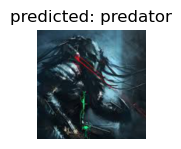

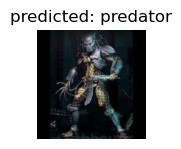

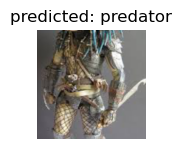

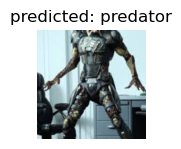

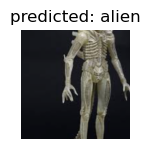

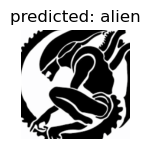

In [18]:
visualize_model(model_ft)

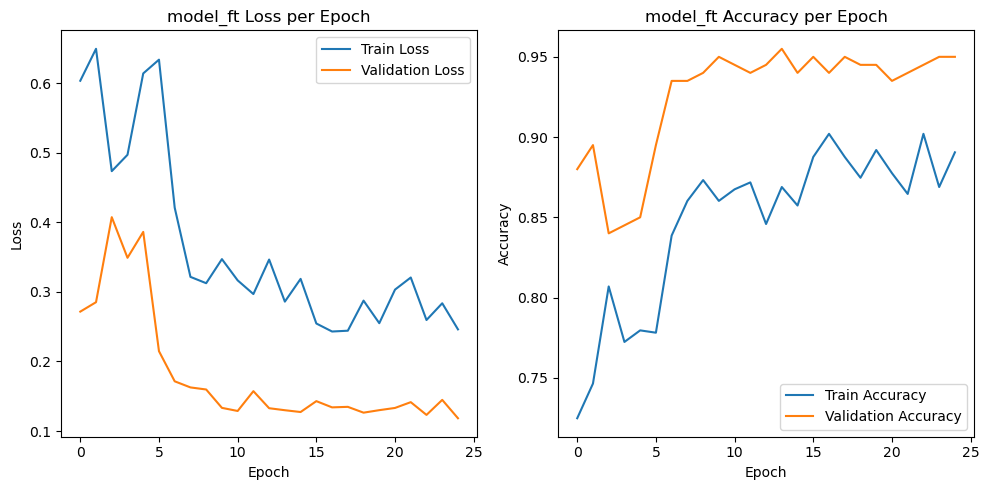

In [21]:
# --- 11. Plot Training History ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('model_ft Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('model_ft Accuracy per Epoch')

plt.tight_layout()
plt.show()

In [37]:
from torch.utils.data import DataLoader
test_dataset = datasets.ImageFolder("alien_predator/alien_vs_predator_thumbnails/data/train", transform=data_transforms['train'])
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
# --- 12. Testing and Evaluation ---
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

model_ft.eval()
all_preds = []
all_labels = []

all_probs = []
all_labels1 = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_ft(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

        all_probs.extend(probs.cpu().numpy())
        all_labels1.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

all_probs = np.array(all_probs)
all_labels1 = np.array(all_labels1)

n_classes = len(class_names)

# Binarize labels using the class index order [0...6]
labels_onehot = label_binarize(all_labels1, classes=np.arange(n_classes))


Classification Report:
              precision    recall  f1-score   support

       alien       0.96      0.98      0.97       347
    predator       0.98      0.96      0.97       347

    accuracy                           0.97       694
   macro avg       0.97      0.97      0.97       694
weighted avg       0.97      0.97      0.97       694



In [44]:
n_classes

2

In [54]:
labels_onehot

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [50]:
all_probs[:, 1]

array([1.22011295e-02, 1.26588612e-03, 1.12029947e-02, 4.31976095e-03,
       1.34665640e-02, 9.07412032e-05, 4.61472059e-03, 2.30611325e-03,
       5.30987745e-05, 1.20962318e-02, 6.85282634e-04, 6.38224959e-01,
       3.31641614e-01, 6.46416377e-03, 6.00009598e-02, 2.14072480e-03,
       5.90893440e-04, 8.66416784e-04, 3.16436589e-02, 1.20192053e-04,
       3.43528390e-01, 2.06476152e-02, 7.21212998e-02, 6.92014489e-03,
       3.20188016e-01, 1.19420269e-03, 1.95891988e-02, 4.13580006e-03,
       6.85706921e-03, 1.67600904e-02, 1.45696476e-02, 9.67474305e-04,
       2.38471566e-05, 9.84053593e-03, 3.71003291e-03, 2.87387259e-02,
       1.05691031e-02, 3.14689751e-05, 1.34059787e-02, 2.35451926e-02,
       4.21374134e-05, 2.11876794e-03, 9.62991361e-03, 1.12519972e-01,
       2.53755157e-03, 3.47123318e-03, 6.96843583e-03, 4.58742827e-01,
       2.63325148e-03, 1.62468478e-03, 2.97346851e-03, 3.83378542e-03,
       2.67047109e-03, 1.47899473e-03, 1.46595718e-04, 1.00233906e-03,
      

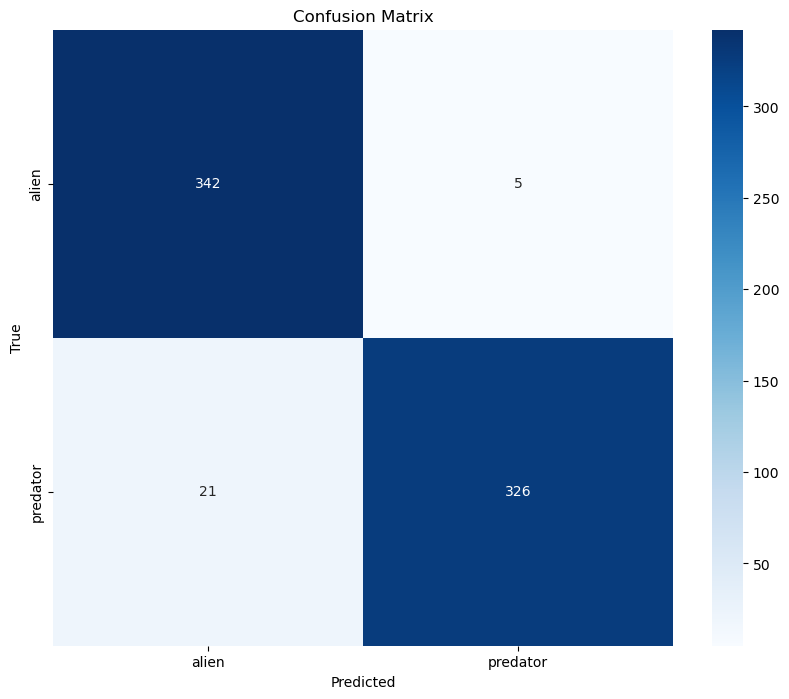

In [41]:
# --- 13. Confusion Matrix ---
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

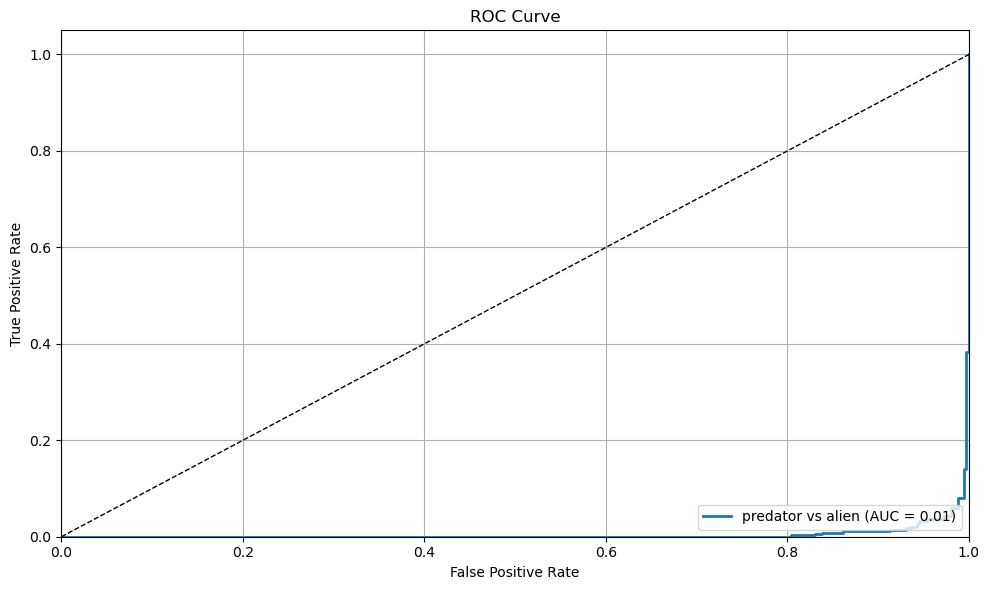

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

if n_classes == 2:
    # Binary classification (1 output neuron)
    # If your model uses sigmoid, all_probs has shape [N, 1]
    probs = all_probs[:, 0]  # predicted probability of class 1
    fpr, tpr, _ = roc_curve(all_labels1, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[1]} vs {class_names[0]} (AUC = {roc_auc:.2f})", lw=2)
else:
    # Multi-class (softmax, multiple outputs)
    labels_onehot = label_binarize(all_labels1, classes=np.arange(n_classes))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})", lw=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Training Only Classifier

In [22]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [23]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/25
----------
train Loss: 0.6351 Acc: 0.6744
val Loss: 0.6210 Acc: 0.6950

Epoch 1/25
----------
train Loss: 0.6090 Acc: 0.7550
val Loss: 0.3462 Acc: 0.8500

Epoch 2/25
----------
train Loss: 0.4703 Acc: 0.7882
val Loss: 0.2911 Acc: 0.8650

Epoch 3/25
----------
train Loss: 0.6492 Acc: 0.7478
val Loss: 0.7045 Acc: 0.7500

Epoch 4/25
----------
train Loss: 0.5017 Acc: 0.8012
val Loss: 0.2347 Acc: 0.9200

Epoch 5/25
----------
train Loss: 0.5366 Acc: 0.7911
val Loss: 0.2117 Acc: 0.9100

Epoch 6/25
----------
train Loss: 0.5122 Acc: 0.7911
val Loss: 0.4150 Acc: 0.8400

Epoch 7/25
----------
train Loss: 0.4324 Acc: 0.7983
val Loss: 0.2153 Acc: 0.9000

Epoch 8/25
----------
train Loss: 0.3837 Acc: 0.8401
val Loss: 0.2007 Acc: 0.9200

Epoch 9/25
----------
train Loss: 0.4058 Acc: 0.8213
val Loss: 0.2137 Acc: 0.9150

Epoch 10/25
----------
train Loss: 0.3472 Acc: 0.8300
val Loss: 0.2115 Acc: 0.9000

Epoch 11/25
----------
train Loss: 0.4356 Acc: 0.7983
val Loss: 0.1932 Acc: 0.9200

Ep

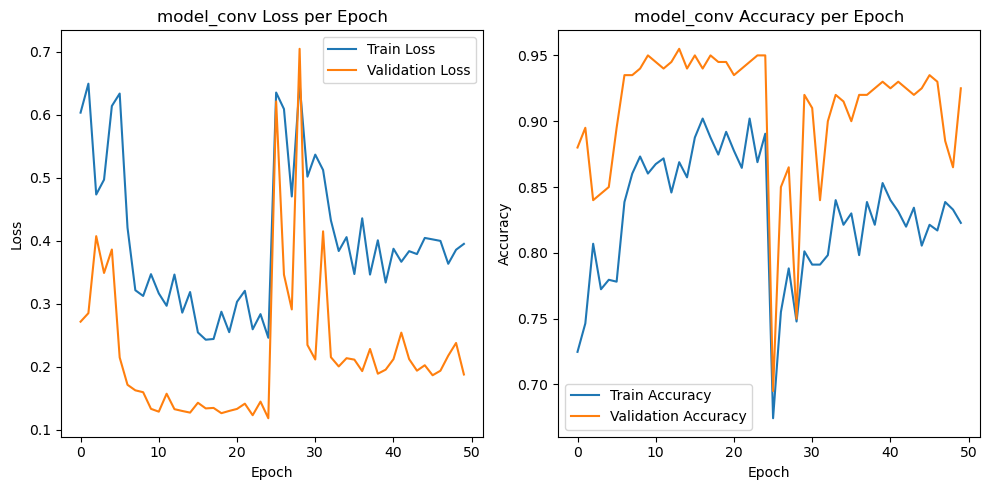

In [24]:
# --- 11. Plot Training History ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('model_conv Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('model_conv Accuracy per Epoch')

plt.tight_layout()
plt.show()

In [26]:
torch.save(model_conv.state_dict(), 'restnet_model_conv.pth')

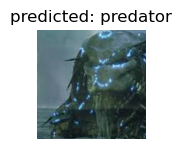

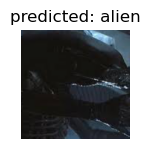

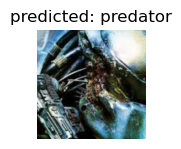

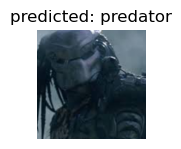

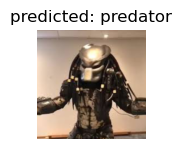

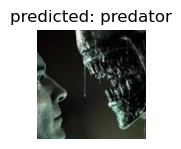

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [57]:
model_conv.eval()
all_preds = []
all_labels = []

all_probs = []
all_labels1 = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_conv(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

        all_probs.extend(probs.cpu().numpy())
        all_labels1.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

all_probs = np.array(all_probs)
all_labels1 = np.array(all_labels1)

n_classes = len(class_names)

# Binarize labels using the class index order [0...6]
labels_onehot = label_binarize(all_labels1, classes=np.arange(n_classes))


Classification Report:
              precision    recall  f1-score   support

       alien       0.91      0.95      0.93       347
    predator       0.95      0.91      0.93       347

    accuracy                           0.93       694
   macro avg       0.93      0.93      0.93       694
weighted avg       0.93      0.93      0.93       694



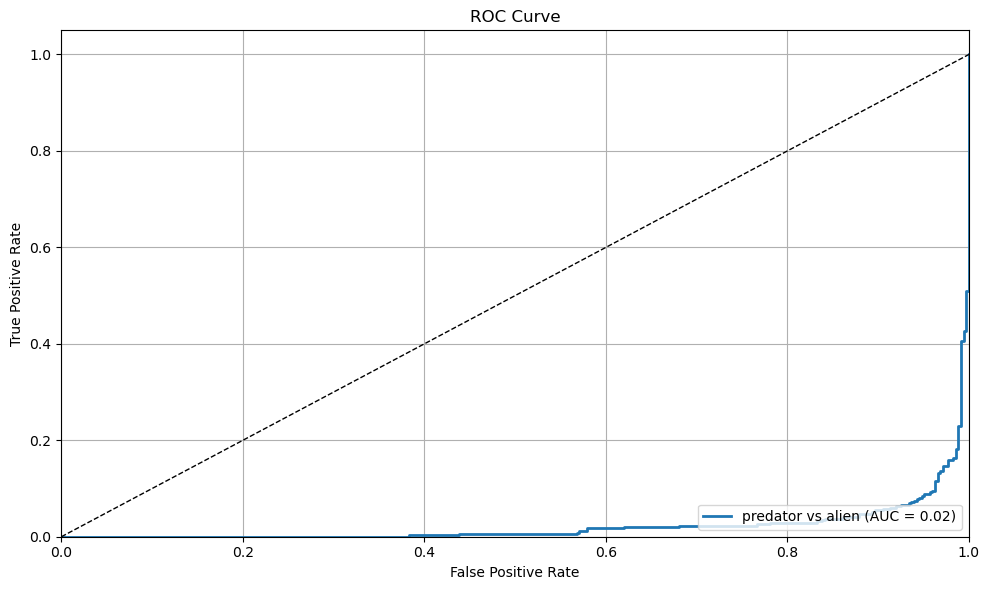

In [58]:
plt.figure(figsize=(10, 6))

if n_classes == 2:
    # Binary classification (1 output neuron)
    # If your model uses sigmoid, all_probs has shape [N, 1]
    probs = all_probs[:, 0]  # predicted probability of class 1
    fpr, tpr, _ = roc_curve(all_labels1, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[1]} vs {class_names[0]} (AUC = {roc_auc:.2f})", lw=2)
else:
    # Multi-class (softmax, multiple outputs)
    labels_onehot = label_binarize(all_labels1, classes=np.arange(n_classes))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})", lw=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

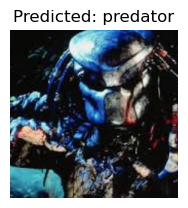

In [33]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a function to load and preprocess the image
def preprocess_image(image_path):
    # Open the image and convert it to RGB
    img = Image.open(image_path).convert('RGB')
    # Apply the transformations
    img_tensor = data_transform(img)
    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

# img_path = r'/media/winswe/DATA/OfficeShare/mws/Learning/GreenHeacker/022-ArtificialIntelligenceCrashCourse/alien_predator/alien_vs_predator_thumbnails/data/train/alien/1.jpg'
img_path = r'/media/winswe/DATA/OfficeShare/mws/Learning/GreenHeacker/022-ArtificialIntelligenceCrashCourse/alien_predator/alien_vs_predator_thumbnails/data/train/predator/0.jpg'

# img_tensor = preprocess_image(img_path)

visualize_model_predictions(
    model_conv,
    img_path
)

plt.ioff()
plt.show()